### Imports

In [459]:
import numpy as np
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns
from datetime import datetime
import time

from sklearn.metrics import mean_absolute_error

### Read Data

In [489]:
ds = pd.read_csv('ds.csv')
df=ds.copy()

### Outlier Removal

In [490]:
median = df['arrival_delay'].median()
std = df['arrival_delay'].std()
outliers = (df['arrival_delay'] - median).abs() > std
df.loc[outliers, 'arrival_delay'] =median


### Feature Selection

In [491]:
categorical_feat=['trip_date','stop_id','trip_id','route_id','stop_sequence','stop_lat','stop_lon','shifted_col']
droppped_features=['stop_name','sch_arrival_time', 'sch_departure_time', 'departure_time','departure_delay']


df.drop(df[df['arrival_time'] == -1].index, inplace = True) 
df = df.sort_values(by=['arrival_time'], ascending=True)

df['shifted_col'] = df['arrival_time'].shift()
df['shifted_col'] = df['shifted_col'].fillna(0)
df['shifted_col'] = df['shifted_col'].astype('int64')
df.head()
df.loc[df['stop_sequence'] == 1, 'shifted_col'] = 0
df['running_time'] = df['arrival_time'] - df['shifted_col']
df.loc[df['stop_sequence'] == 1, 'running_time'] = 0
df.loc[df['shifted_col'] == 0, 'running_time'] = 0

df=df.drop(droppped_features+categorical_feat,axis=1)
df['arrival_time'] = pd.to_datetime(df['arrival_time']).view('int64')
df['arrival_delay']=df['arrival_delay']/60
cols = list(df)
df_for_training = df[cols].astype(float)
scaler = MinMaxScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)



### Dataset Split

In [463]:
DatasetX = []
DatasetY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14 
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    DatasetX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    DatasetY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

DatasetX, DatasetY = np.array(DatasetX), np.array(DatasetY)

test_split= int(DatasetX.shape[0]*0.1)
train_split=DatasetX.shape[0]-test_split
print(test_split,train_split)
testX=DatasetX[-test_split:].copy()
trainX=DatasetX[0:train_split].copy()
testY=DatasetY[-test_split:].copy()
trainY=DatasetY[0:train_split].copy()
print('trainX shape == {}.'.format(trainX.shape))
print('testX shape == {}'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))
print('trainY shape == {}'.format(trainY.shape))

455 4100
trainX shape == (4100, 14, 3).
testX shape == (455, 14, 3)
testY shape == (455, 1).
trainY shape == (4100, 1)


### Model Architecture

In [464]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 14, 64)            17408     
                                                                 
 lstm_19 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


### Training

Epoch 1/40
33/33 [==============================] - 4s 45ms/step - loss: 0.4067 - val_loss: 0.0243
Epoch 2/40
33/33 [==============================] - 1s 35ms/step - loss: 0.0458 - val_loss: 0.0050
Epoch 3/40
33/33 [==============================] - 1s 34ms/step - loss: 0.0378 - val_loss: 0.0046
Epoch 4/40
33/33 [==============================] - 1s 33ms/step - loss: 0.0362 - val_loss: 0.0044
Epoch 5/40
33/33 [==============================] - 1s 35ms/step - loss: 0.0365 - val_loss: 0.0043
Epoch 6/40
33/33 [==============================] - 1s 34ms/step - loss: 0.0354 - val_loss: 0.0043
Epoch 7/40
33/33 [==============================] - 1s 35ms/step - loss: 0.0339 - val_loss: 0.0042
Epoch 8/40
33/33 [==============================] - 1s 34ms/step - loss: 0.0332 - val_loss: 0.0047
Epoch 9/40
33/33 [==============================] - 1s 33ms/step - loss: 0.0340 - val_loss: 0.0051
Epoch 10/40
33/33 [==============================] - 1s 34ms/step - loss: 0.0329 - val_loss: 0.0040
Epoch 11/

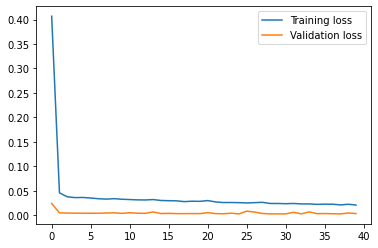

In [465]:
history = model.fit(trainX, trainY, epochs=40, batch_size=100, validation_split=0.2, verbose=1)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [466]:
prediction = model.predict(trainX) #shape = (n, 1) where n is the n_days_for_prediction
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

129/129 [==============================] - 1s 6ms/step


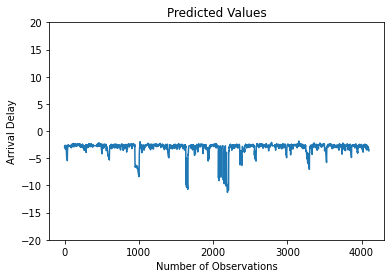

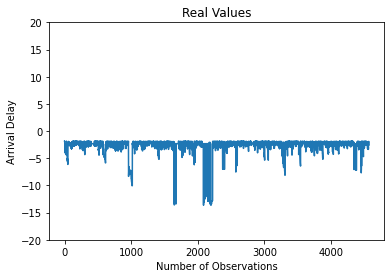

In [481]:
f1 = plt.figure()
f2 = plt.figure()
ax1 = f1.add_subplot(111)
ax1.axis(ymin=-20,ymax=20)

ax1.plot(np.arange(0,len(y_pred_future)), y_pred_future)
ax1.set_title('Predicted Values')
ax1.set_xlabel('Number of Observations')
ax1.set_ylabel('Arrival Delay')
ax2 = f2.add_subplot(111)
ax2.axis(ymin=-20,ymax=20)
ax2.set_title('Real Values')
ax2.plot(np.arange(0,len(df["arrival_delay"])), df["arrival_delay"])
ax2.set_xlabel('Number of Observations')
ax2.set_ylabel('Arrival Delay')
plt.show()


In [482]:
#Training on test Data
prediction2 = model.predict(testX) #shape = (n, 1) where n is the n_days_for_prediction
prediction_copies2 = np.repeat(prediction2, df_for_training.shape[1], axis=-1)
y_pred_future1 = scaler.inverse_transform(prediction_copies2)[:,0]
print(testX.shape)

15/15 [==============================] - 0s 5ms/step
(455, 14, 3)


### Prediction on test-set

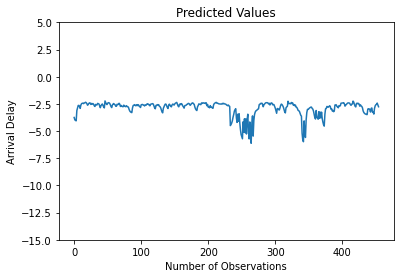

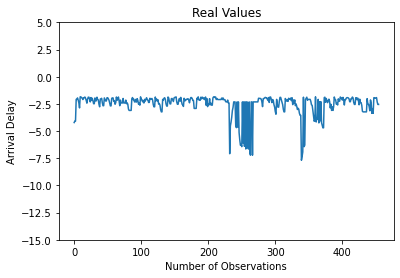

,arrival_delay,arrival_time,running_time
2126,-1.866667,1669170098,0
76,-1.900000,1669170137,39
2035,-1.866667,1669170229,92
3008,-2.166667,1669170295,66
2270,-2.733333,1669170343,48


In [483]:
f1 = plt.figure()
f2 = plt.figure()
testY_unscaledValues=df['arrival_delay'].iloc[-test_split:].to_numpy().flatten()

ax1 = f1.add_subplot(111)
ax1.axis(ymin=-15,ymax=5)
ax1.plot(np.arange(0,len(y_pred_future1)), y_pred_future1)
ax1.set_title('Predicted Values')
ax1.set_xlabel('Number of Observations')
ax1.set_ylabel('Arrival Delay')
ax2 = f2.add_subplot(111)
ax2.axis(ymin=-15,ymax=5)
ax2.set_title('Real Values')
ax2.plot(np.arange(0,len(testX)), testY_unscaledValues)
ax2.set_xlabel('Number of Observations')
ax2.set_ylabel('Arrival Delay')
plt.show()
df.head()

In [484]:
accuracy=mean_absolute_error(testY_unscaledValues,y_pred_future1)
print("Accuracy of the model on the test Data: ", accuracy)




Accuracy of the model on the test Data:  0.6075621958791991


In [485]:
df1 = pd.DataFrame([y_pred_future1,testY_unscaledValues]).transpose()
df1.columns = ['Predicted Values', 'Actual Values']
df1.head(10)

,Predicted Values,Actual Values
0,-3.748395,-4.216667
1,-3.967012,-4.083333
2,-4.022313,-4.083333
3,-4.057290,-2.083333
4,-3.113455,-2.083333
5,-2.862320,-1.950000
6,-2.648578,-2.150000
7,-2.635501,-2.400000
8,-2.709344,-2.866667
9,-2.913051,-1.850000


### Prediction for future 20 stops

In [486]:
predict_stops=20
temp_feature_data=testX[-1]
temp_dropped_data=ds.iloc[-1]
maxStopSequence=ds['stop_sequence'].max()
trips=pd.read_csv('trips.csv')
stops=pd.read_csv("stops.csv")
stop_times=pd.read_csv("stop_times.csv")
trip_id_list=trips.loc[(trips['route_id']==6612) & (trips['direction_id']==1)]
l1 = np.sort(trip_id_list["trip_id"].to_numpy())
temp1 = temp_feature_data.reshape(1,14,3)
list_predict = []



for i in range(predict_stops):
  prediction1 = model.predict(temp1) #shape = (n, 1) where n is the n_days_for_prediction
  prediction_copies1 = np.repeat(prediction1, df_for_training.shape[1], axis=-1)

  tp = stop_times.loc[(stop_times['trip_id']==temp_dropped_data.trip_id)]
  maxStopSequence = tp["stop_sequence"].max()

  # maxStopSequence=temp_dropped_data.trip_id
  delay = scaler.inverse_transform(prediction_copies1)[:,0]
  stop_sequence =  (temp_dropped_data.stop_sequence + 1)%(maxStopSequence)
  if(stop_sequence==0):
    stop_sequence=stop_sequence+1
  if(temp_dropped_data.stop_sequence==maxStopSequence):
    ind1 = np.where(l1 == temp_dropped_data.trip_id)
    ind1 = ind1[0][0] + 1
    ind2=(ind1%len(l1))
  else:
    ind2=np.where(l1 == temp_dropped_data.trip_id)
    ind2 = ind2[0][0]
  trip_id_final = l1[ind2]
  temp_row = stop_times.loc[(stop_times['trip_id']==trip_id_final) & (stop_times['stop_sequence']==stop_sequence)]
  temp_unix = temp_dropped_data["arrival_time"]
  temp_time = datetime.utcfromtimestamp(temp_unix).strftime('%Y-%m-%d')
  final_time = temp_time + str(temp_row["arrival_time"].values[0])
  schdate=datetime.strptime(final_time, "%Y-%m-%d %H:%M:%S")
  schUnixTime=time.mktime(schdate.timetuple())
  arrival_time=schUnixTime+delay
  running_time=arrival_time-temp_unix
  
  final_arr = [delay, arrival_time, running_time]
  final_arr_np = np.reshape(np.asarray(final_arr), (1,3))
  final_arr_np=scaler.transform(final_arr_np)

  temp1_final = np.append(temp1[:,1:,:][0], final_arr_np[0])
  temp2 = temp1_final.reshape(1,14,3)
  temp1 = temp2
  temp_dropped_data.stop_sequence = stop_sequence
  temp_dropped_data.trip_id = trip_id_final

  sn1 = stops.loc[(stops['stop_id']==temp_row["stop_id"].values[0])]
  sn2= trips.loc[(trips['trip_id']==trip_id_final)] 

  df2arr = [sn1["stop_name"].values[0], sn2["trip_headsign"].values[0], final_arr[0], final_time]
  list_predict.append(df2arr)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (0,1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


1/1 [==============================] - 0s 22ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

1/1 [==============================] - 0s 18ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

1/1 [==============================] - 0s 22ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

1/1 [==============================] - 0s 21ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

1/1 [==============================] - 0s 18ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

1/1 [==============================] - 0s 25ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

1/1 [==============================] - 0s 20ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

In [487]:
list_predict = np.asarray(list_predict)
# list_predict.shape
dataframe_final = pd.DataFrame(list_predict, columns = ['stop_name','trip_name','delay', 'scheduled_time'])

dataframe_final

<ipython-input-487-47a5f8ebbf14>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  list_predict = np.asarray(list_predict)


,stop_name,trip_name,delay,scheduled_time
0,Eastbound W 16 Ave @ Trutch St,2 Macdonald - 16th,[-2.7610295],2022-12-02 7:57:53
1,Burrard Station @ Bay 4,2 Macdonald - 16th,[-3.2714865],2022-12-02 7:34:00
2,Burrard Station @ Bay 1,2 Macdonald - 16th,[-3.792659],2022-12-02 7:35:48
3,Southbound Burrard St @ Robson St,2 Macdonald - 16th,[-4.3294787],2022-12-02 7:37:02
4,Southbound Burrard St @ Barclay St,2 Macdonald - 16th,[-4.9326444],2022-12-02 7:37:36
5,Southbound Burrard St @ Nelson St,2 Macdonald - 16th,[-5.6188297],2022-12-02 7:38:12
6,Southbound Burrard St @ Davie St,2 Macdonald - 16th,[-6.354597],2022-12-02 7:39:21
7,Southbound Burrard St @ Harwood St,2 Macdonald - 16th,[-7.1609564],2022-12-02 7:39:57
8,Westbound Cornwall Ave @ Cypress St,2 Macdonald - 16th,[-7.9416566],2022-12-02 7:44:58
9,Westbound Cornwall Ave @ Arbutus St,2 Macdonald - 16th,[-8.648892],2022-12-02 7:46:12
